# Relevance Classification Task

#### Team Members
Vishesh Kishore 202392175 \
Niskarsha Ghimire, 202390729 \
Nishant Anilkumar Khadse, 202384013 \
Abdulaziz Sultan F Alsahli, 202354056  

# 1. Overview

Write the conclusive summary of the assignment here, what we did, learning outcomes etc.  (4-5) sentences.

### Importing Libraries and Packages

In [76]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [77]:
# Loading training dataset
data = pd.read_parquet('relevance_train.parquet', engine='pyarrow')

### Exploratory Data Analysis

In [78]:
# Shape of the data
data.shape

(19758, 10)

In [79]:
data.sample(5)

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
21340,83deab38-ae42-11e5-9ab0-884d1cc4b33e,0,David Ignatius,<p>One of the arguments for the Iran nuclear d...,By David Ignatius,"Despite the nuclear deal, Iran continues its e...",815,Find documents that discuss Washington Post jo...,Relevant documents include those that mention ...,Jason Rezaian released from Iran
23838,a9330d2a-4aaa-11e1-a4d1-23c1d0ce2e96,0,Ramit Plushnick-Masti,"<p><span class=""dateline"">TIVOLI, Tex. —</span...",By Anne Midgette,Art Review: ‘The Baroque Genius of Giovanni Be...,820,Identify documents that specify the mortality ...,A relevant document will identify the mortalit...,bacterial infection mortality rate
16555,c4216948c6c597c6308a5254c6840bd3,0,Prof. Glen Whitman (guest-blogging),<p>Undead film and fiction are burgeoning with...,By Prof. Glen Whitman (guest-blogging),Tragedy of the blood commons,805,Would eating invasive species be a viable meth...,Relevant documents identify invasive species i...,eating invasive species
2870,5a9d40e87e27a83a04501f1500646ea7,0,Rick Noack,<p>BERLIN — The number of refugees and migrant...,By Rick Noack,Over a million refugees and migrants arrived i...,362,Identify incidents of human smuggling.,A relevant document shows an incident of human...,human smuggling
9339,b94f7cfa-da7c-11e5-925f-1d10062cc82d,0,Editorial Board,"<p>THE RUNNING <a href=""https://www.washington...",By Editorial Board,The fight between Apple and law enforcement sh...,426,Provide information on the use of dogs worldwi...,Relevant items include specific information on...,"law enforcement, dogs"


In [80]:
data['body'][0]

'<p>More than 60 years ago, a fair-skinned Irish politician\xa0named Sally Mulready was born into a home for unwed mothers called St. Patrick’s. It sat on a road named\xa0Navan in Dublin, and Mulready\xa0was one of four siblings born there. Her brother John never made it out of St. Pat’s. Like hundreds of other babies born into an Irish\xa0homes for “fallen women,” John\xa0died in 1947. He was two months old.</p>\\n<p>“Inanition,” his death record read, <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">according to RTE News</a>. “Failure to thrive.”</p>\\n<p>But RTE News <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">said</a>\xa0the\xa0record carried a mystery. John for some reason wasn’t buried until 1950 — three years after his death. The oddity was first discarded as a clerical error.</p>\\n<p>But it wasn’t. John’s records had\xa0the designation “AS,” or\xa0“anatomical study.” His infant remains

In [81]:
data['description'][1000]

'A relevant document would discuss the frequency of vicious black bear attacks worldwide and the possible causes for this savage behavior.'

In [82]:
data['narrative'][1000]

'It has been reported that food or cosmetics sometimes attract hungry black bears, causing them to viciously attack humans. \nRelevant documents would include the aforementioned causes as well as speculation preferably from the scientific community as to other possible causes of vicious attacks by black bears.\n A relevant document would also detail steps taken or new methods devised by wildlife officials to control and/or modify the savageness of the black bear.'

In [83]:
data['topic_title'][1000]

'Black Bear Attacks'

In [84]:
# Percentage of relevant and non-relevant articles
data['judgement'].value_counts(normalize=True).mul(100).round(3).astype(str) + '%'

0    84.285%
1    15.715%
Name: judgement, dtype: object

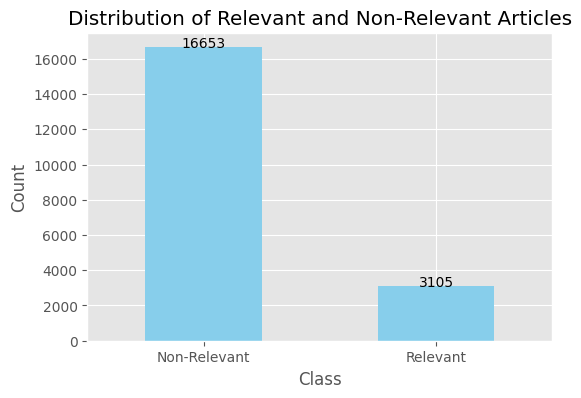

In [85]:
labels = {0: 'Non-Relevant', 1: 'Relevant'}
value_count = data['judgement'].map(labels).value_counts()

# Plotting
plt.figure(figsize=(6, 4))
bars = value_count.plot(kind='bar', color='skyblue')
plt.title('Distribution of Relevant and Non-Relevant Articles')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Relevant', 'Relevant'], rotation=0)
# plt.show()

# Annotating the bars with count values
for i, count in enumerate(value_count):
    bars.text(i, count + 0.1, str(count), ha='center')

plt.show()


In [86]:
data.isnull()
# data.isnull().values.any()

data.isnull().sum()

doc_id            0
judgement         0
author         1573
body             69
byline         1508
title             0
topic_id          0
description       0
narrative         0
topic_title       0
dtype: int64

In [87]:
# removing null values from body column
data = data.dropna(subset=['body'])

In [88]:
# Dropping columns that are not relevant for pre-processing the data
data.drop(columns=['doc_id', 'topic_id', 'byline'], inplace=True)

In [89]:
data['author'].nunique()

3363

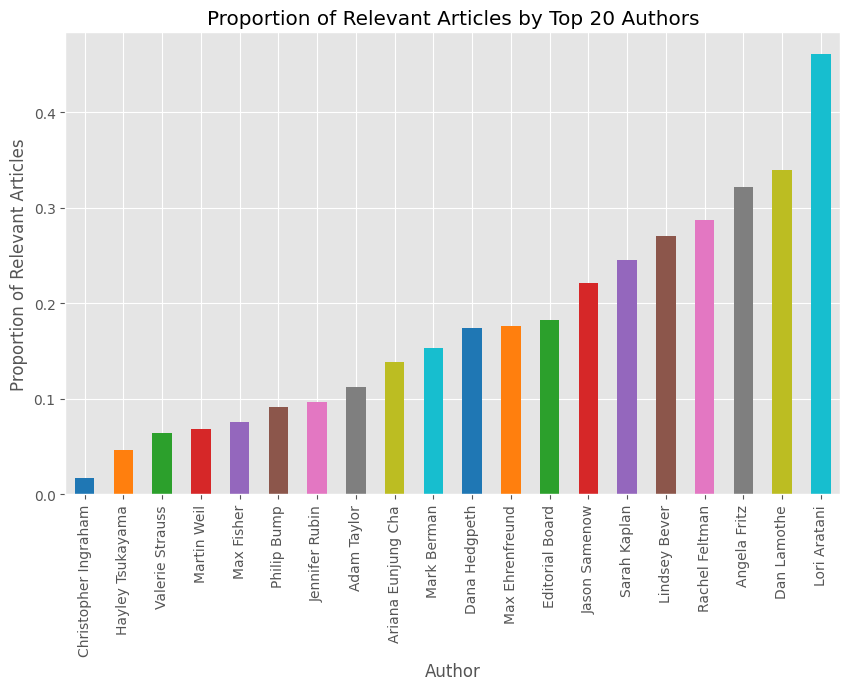

In [90]:
top_20_authors = data['author'].value_counts().nlargest(20).index
authors = data[data['author'].isin(top_20_authors)]

author_relevance = authors.groupby('author')['judgement'].mean().sort_values()

colors = sns.color_palette('tab10', len(author_relevance))

plt.figure(figsize=(10, 6))
author_relevance.plot(kind='bar', color=colors)
plt.title('Proportion of Relevant Articles by Top 20 Authors')
plt.xlabel('Author')
plt.ylabel('Proportion of Relevant Articles')
plt.xticks(rotation=90)
plt.show()


### Pre-Processing the text data

In [91]:
#Importing libraries
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Function to perform embedding techniques
def text_cleaning(text):
    
    # Remove html tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Perform stemming using Porter Stemmer algorithm
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a single string
    processed_text = ' '.join(stemmed_tokens)

    # Return the processed text
    return processed_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/visheshkishore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/visheshkishore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### WordCloud to Analyize article relevance

In [92]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(text):

    # Generate a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


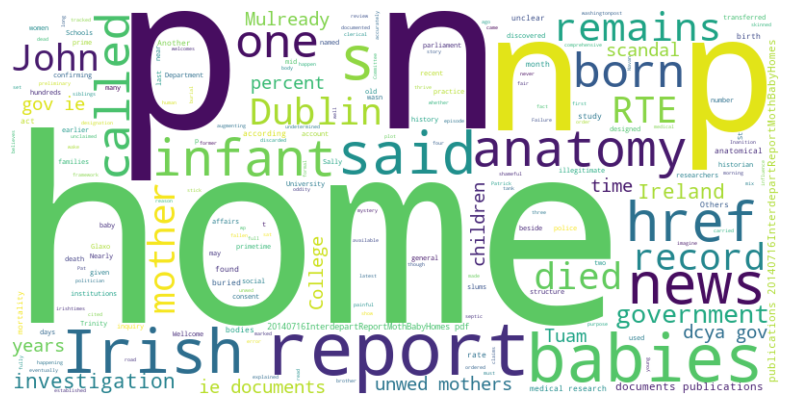

In [93]:
wordcloud(data['body'][0])

In [94]:
data['body'][0]

'<p>More than 60 years ago, a fair-skinned Irish politician\xa0named Sally Mulready was born into a home for unwed mothers called St. Patrick’s. It sat on a road named\xa0Navan in Dublin, and Mulready\xa0was one of four siblings born there. Her brother John never made it out of St. Pat’s. Like hundreds of other babies born into an Irish\xa0homes for “fallen women,” John\xa0died in 1947. He was two months old.</p>\\n<p>“Inanition,” his death record read, <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">according to RTE News</a>. “Failure to thrive.”</p>\\n<p>But RTE News <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">said</a>\xa0the\xa0record carried a mystery. John for some reason wasn’t buried until 1950 — three years after his death. The oddity was first discarded as a clerical error.</p>\\n<p>But it wasn’t. John’s records had\xa0the designation “AS,” or\xa0“anatomical study.” His infant remains

In [95]:
data['description'][0]

'Pertinent documents will reflect the fact that women continue to be poorly represented in parliaments across the world, and the gap in political power between the sexes is very wide, particularly in the Third World.'

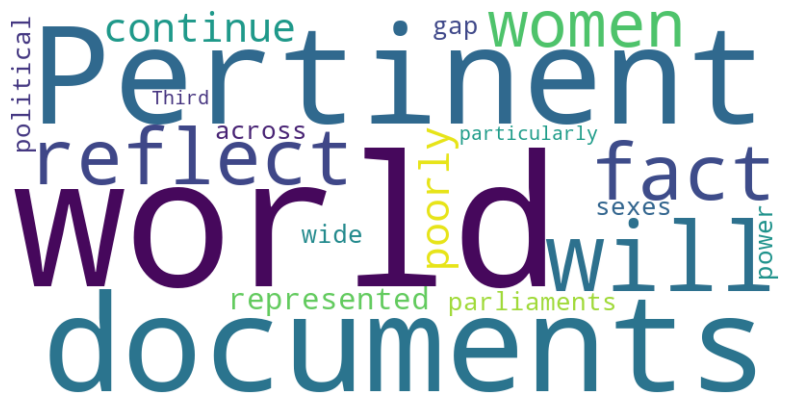

In [96]:
wordcloud(data['description'][0])

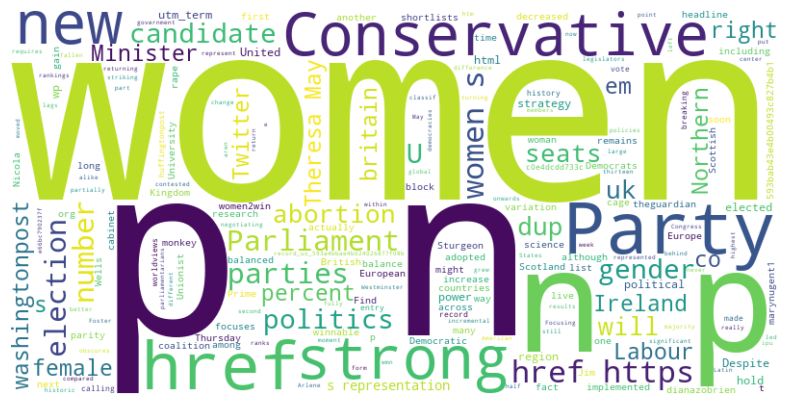

In [97]:
wordcloud(data['body'][6])

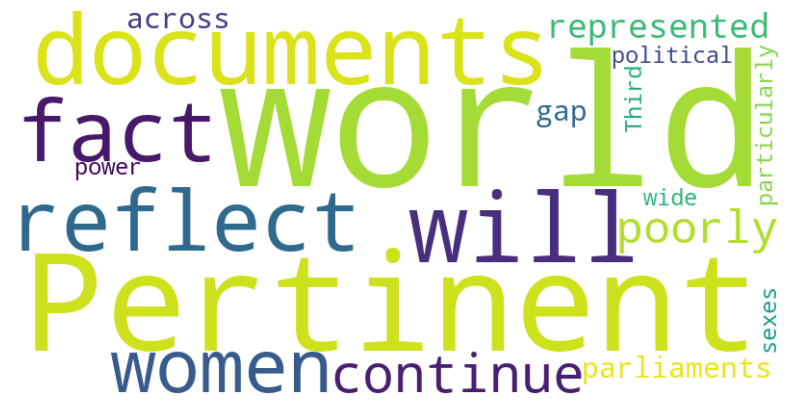

In [98]:
wordcloud(data['description'][6])

It can be observed from the wordcloud plot above that the content of the article (body) contains words that seem relevant to user's information need (description). The article is somewhat related about political elections and the description of the also represents the same. 

It can be concluded that wordcloud gave us qualitative understanding of the language used in relevant and non-relevant articles.

# 2. Methods

To kickstart the project, Exploratory Data Analysis was performed on the training dataset to get the overall impression of the given data. As per the dataset description, it consists of a news paper article  (doc_id, author, body, byline, title) and a description of what a person was looking for (i.e. their information need (see fields topic_id, description, narrative and topic_title).

After performing functions to apply EDA, we observed that there exist imbalance in the data with not-relevant articles being 84% of the entire training data. That is, most of the articles are not relevant to the user's information need. We considered this class imbalance when interpreting the performance of the classification model. For time being, we will proceed with the data as it is and monitor the model performance with different parameters. It was observed that there are null values in training dataset. The columns that has null values are ['author', 'body', 'byline']. Since this is the text dataset, it makes sense to remove those instances rather than imputing some random text values. The graph was plotted representing the proportion of relevant articles authored by top 20 authors from the training data. There are 3365 unique artists present in the training data, therefore we plot the graph for only top 20 authors to increase readability.

After carefully exploring the text data, the process of removing html tags from body, lower casing, removing stopwords and stemming was applied on 1st instance of the training dataset via python function. Furthermore, wordcloud for the same instance was plotted. It is observed from the wordcloud that the user's information need (description) do not seem relevant to the content of the article (body). As observed from the content of the wordcloud, the article somehow seems something related to Ireland whereas the description revolves aroung Woman in Parliament. Conclusively, the article is not relevant as it was labelled in the data also.

Furthermore, the columns ['body', 'title', 'description', 'narrative'] were combined as a single column ['combined_text']. Later on, TF-IDF was applied on the 'combined_text' column to produce a numerical vector representation of the word. TF-IDF was performed to minimize the weighting of frequent terms while making infrequent terms have a higher impact.

The TF-IDF vector matrix was considered as independent variable (X) and the judgement column was taken as the target variable. The data was segmented into training and validation set to apply deep learning models. 


### Applying Text Cleaning function on training dataset

In [99]:
# Applying text cleaning function to each column of the training dataset
data[['body', 'title', 'description', 'narrative']] = data[['body', 'title', 'description', 'narrative']].applymap(text_cleaning)

/var/folders/m_/d9ytr15j7xs96j0pg4x6z7dm0000gn/T/ipykernel_68642/860189693.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [101]:
data['combined_text'] = data['body'] + data['description'] + data['narrative'] + data['title']

In [102]:
data.head(3)

,judgement,author,body,title,description,narrative,topic_title,combined_text
0,0,Terrence McCoy,60 year ago fair-skin irish politician name sa...,report irish babi home document use infant med...,pertin document reflect fact women continu poo...,pertin document relat issu discuss lack repres...,Women in Parliaments,60 year ago fair-skin irish politician name sa...
1,0,Brian McNoldy,hurrican fred form weekend far eastern atlant ...,hurrican fred fountain ‘ first ’ atlant ocean,pertin document reflect fact women continu poo...,pertin document relat issu discuss lack repres...,Women in Parliaments,hurrican fred form weekend far eastern atlant ...
2,0,Editorial Board,eight year ago month inspir movement took hold...,ukrain slide away democraci,pertin document reflect fact women continu poo...,pertin document relat issu discuss lack repres...,Women in Parliaments,eight year ago month inspir movement took hold...


In [103]:
# Combining columns into a single column 'combined_text'
data_new = data[['combined_text', 'judgement']].copy()

In [104]:
data_new.sample(5)

,combined_text,judgement
1064,name janin van norman\nposit chief branch fore...,0
13885,case doubt “ south dakota independ ’ ‘ friend ...,0
6605,“ priu probabl compost sort recycl reusabl sho...,0
17642,boston — break long silenc wednesday 21-year-o...,1
5611,aug. 18 op- “ friend ask die ” jerald winakur ...,1


### Performing TF-IDF Vectorizer

In [105]:
#Using TF-IDF to form vector of words
articles = list(data_new['combined_text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(articles)
articles = tfidf_vectorizer_vectors.toarray()

### Separating features and target variables

In [106]:
X = articles 
Y = data['judgement']

In [107]:
print(X.shape, Y.shape)

(19689, 20000) (19689,)


In [307]:
# Using validation techniques to split the dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(13782, 20000) (13782,)
(5907, 20000) (5907,)


# 3. Models

## 3.1 Stochastic Gradient Descent

The dataset containes 20000 features in the form of matrix vector. Using a standard distance based model would be computationally expensive, therefore SGD Classfier was chosen as a Machine Learning baseline model. SGD is computationally efficient, especially for high-dimensional feature spaces which makes sense to use it in a text classification problem. 
To validate the model performance, K-Fold cross validation techniques was used with 10 folds using precision as the evaluation metric.

In [109]:
from numpy import mean, std
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score


# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#create SGD Model
lr_clf = SGDClassifier(loss='log_loss', random_state=42)

# evaluate model
scores = cross_val_score(lr_clf, X, Y, scoring='precision', cv=cv, n_jobs=-1)

# report performance
print('Mean precision score for 10 fold cross validation: %.3f (%.3f)' % (mean(scores), std(scores)))


Python(71490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Mean precision score for 10 fold cross validation: 0.824 (0.032)


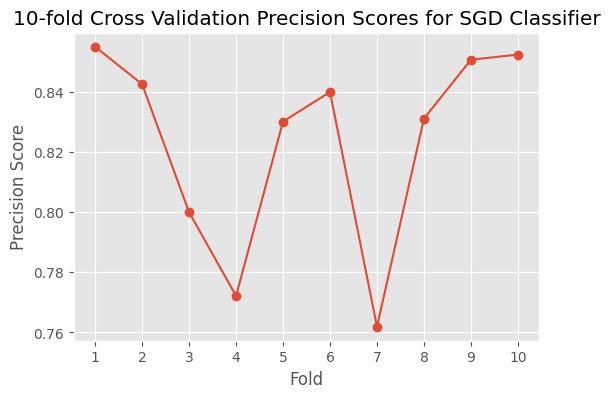

In [111]:
# Plotting the precision scores
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 11), scores, marker='o', linestyle='solid')
plt.title('10-fold Cross Validation Precision Scores for SGD Classifier')
plt.xlabel('Fold')
plt.ylabel('Precision Score')
plt.grid(True)
plt.xticks(np.arange(1, 11))
plt.show()

An average precision score of 82.8% was observed with 10 Fold cross-validation method. Considering SGD Classfier as the baseline model for our methodology, we then apply neural network approach to predict relevant text. 

### 3.2 Three Layer Neural Network Baseline

In [298]:
# Function to create 3 layered NN
def three_layer_nn(neurons):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(20000,), activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])
    return model

    

In [301]:
list_of_neurons = [100, 250, 500, 750]

precisions = []

for neurons in list_of_neurons:
    print(f'\nTraining model with {neurons} neurons in hidden layer')
    model = three_layer_nn(neurons)
    model.fit(X_train, Y_train, epochs=10, batch_size=500, validation_data=(X_val, Y_val), shuffle=True)
    _, precision = model.evaluate(X_val, Y_val)
    precisions.append(precision)

    print('Precision: %.2f' % (precision*100))




Training model with 100 neurons in hidden layer


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.5624 - precision: 0.0833 - val_loss: 0.4066 - val_precision: 0.0000e+00
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3739 - precision: 0.0000e+00 - val_loss: 0.3485 - val_precision: 0.0000e+00
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2811 - precision: 0.0000e+00 - val_loss: 0.3198 - val_precision: 0.0000e+00
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2020 - precision: 0.8380 - val_loss: 0.3393 - val_precision: 0.7276
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1173 - precision: 0.9238 - val_loss: 0.4063 - val_precision: 0.6641
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0472 - precision: 0.9501 - val_loss: 0.5152 - val_precision: 0.6535
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0224 - precision: 0.9788 - val_loss: 0.5681 - val_precision: 0.6257
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0186 - precision

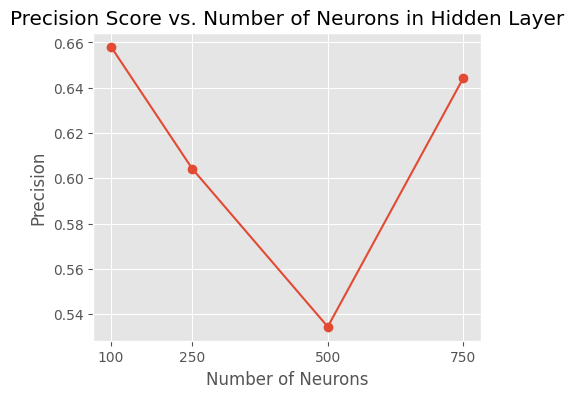

In [302]:
# Plotting
plt.figure(figsize=(5, 4))
plt.plot(list_of_neurons, precisions, marker='o')
plt.title('Precision Score vs. Number of Neurons in Hidden Layer')
plt.xlabel('Number of Neurons')
plt.ylabel('Precision')
plt.xticks(list_of_neurons)
plt.grid(True)
plt.show()

It is observed from the plot that 100 neurons give best precision score. Although we could have explored high number of neurons but that would be computationally expensive.

In [303]:
# Fitting the model with 100 neurons 
model = three_layer_nn(100)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])
model.fit(X_train, Y_train, epochs=10, batch_size=100)

#Loss precision on training set
loss, precision = model.evaluate(X_train, Y_train, verbose=False)
print("Training Precision: {:.4f}". format(precision))

# loss precision on testing set
loss, precision = model.evaluate(X_val, Y_val, verbose=False)
print("Testing Precision: {:.4f}". format(precision))


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4645 - precision: 0.1282
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2356 - precision: 0.8022
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1091 - precision: 0.8984
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0424 - precision: 0.9569
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0255 - precision: 0.9742
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0205 - precision: 0.9801
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0141 - precision: 0.9848
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0114 - precision: 0.9865
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0117 - precision: 0.9836
Epoch 10/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0089 - precision: 0.9844
Training Precision: 0.9889
Testing Precision: 0.6029


In [304]:
print(model.summary())

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_143 (Dense)               │ (None, 100)            │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 500)            │        50,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,305 (23.47 MB)

 Trainable params: 2,051,101 (7.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,102,204 (15.65 MB)

None


Three layered model with feed forward architecture was applied using a python function with number of neurons as the argument.  The first layer is densely connected with ReLu activation function having input shape of 20000. The hidden layer contains 500 neurons, enabling the network to learn more complex patterns. The final layer is the output layer with sigmoid as activation function suitable for binary classification. 

The range of neurons applied are [100, 250, 500, 750] withh 10 epochs, validating the model on validation set. The precision vs neuron plot showed how changing the number of neurons changed the performance of the model. As a result of the graph, we chose to go with 100 neurons in the input layer. 

Precision score on validation set with 100 neurons in input layer: 77.29 %

## 3.3 Deep Layer Neural Network with Embedding Layer

The section implements the Embedding Layer in Keras taking calculated integers of words mapping it to dense vector of embedding. This would involve using both Word Embedding and pre-trained word embeddings. However, word embedding collect more information into fewer dimensions. 

In [273]:
# articles variables with text
data_new
articles = data_new['combined_text'].copy()

In [308]:
# Separating training and validation/test set
articles_train, articles_test, y_train, y_test = train_test_split(articles, Y, test_size=0.25, random_state=42)

Here, we are using Tokenizer class in Keras to implement tokenisation of articles. Each integers maps to a dictionary that encodes the entire corpus, with keys in the dictionary being vocabulary term themselves. These corpus of embedded words will then be passed to Embedding layer in Keras.

In [309]:
# Tokenising the articles 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(articles_train)

# separetly tokenizing train and test articles
X_train = tokenizer.texts_to_sequences(articles_train)
X_test = tokenizer.texts_to_sequences(articles_test)

vocab_size = len(tokenizer.word_index) + 1

The code below appends 0 in text sequence having different length of words in most cases. To overcome this problem of variable length, we used pad_sequence() which pads the sequence of words with zero.

In [310]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 1000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We now have an Embedding layer with input_dim as size of the vocabulary, and output_dim as the embedding_dim which we have chosen 50 as the base value for this model. 

### Effect of adding more hidden layers on model performance

In [318]:
from keras import layers

embedding_dim = 50

def create_model(num_layers):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, input_shape=(1000,)))
    model.add(layers.Flatten())
    model.add(Dense(500, activation='sigmoid', input_shape=(1000,)))
    for _ in range(num_layers):
        model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision'])
    return model

In [319]:
num_layers_range = range(1, 6)  # Number of dense layers: 1 to 5
precision_scores = []

for num_layers in num_layers_range:
    model = create_model(num_layers)
    history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=500)
    loss, precision = model.evaluate(X_test, y_test, verbose=False)
    precision_scores.append(precision)


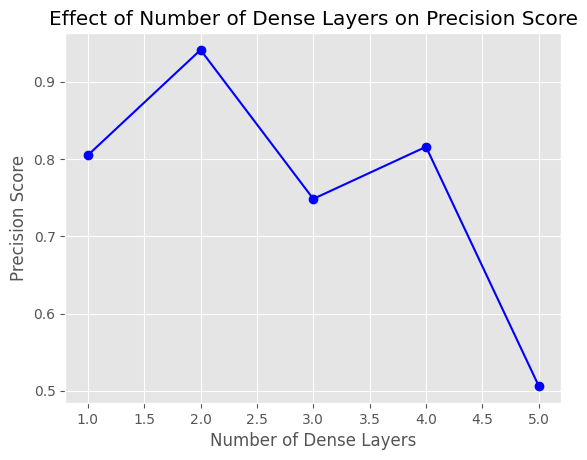

In [321]:
# Plot the results
plt.plot(num_layers_range, precision_scores, marker='o', color = 'blue')
plt.xlabel('Number of Dense Layers')
plt.ylabel('Precision Score')
plt.title('Effect of Number of Dense Layers on Precision Score')
plt.grid(True)
plt.show()

#### Experimenting with Different Activation Functions

In [330]:
# Function to interpret different activation function

def build_model(activation_func):
    embedding_dim = 50

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, input_shape=(1000,)))
    model.add(layers.Flatten())
    model.add(layers.Dense(500, activation=activation_func))
    model.add(layers.Dense(100, activation=activation_func))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['precision'])

    return model

In [346]:
activation_func = ['sigmoid', 'relu', 'tanh', 'softmax', ]
precision_scores_train = []
precision_scores_test = []

for act_func in activation_func:
    model = build_model(act_func)
    history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=500)
    _, precision_train = model.evaluate(X_train, y_train, verbose=False)
    _, precision_test = model.evaluate(X_test, y_test, verbose=False)
    precision_scores_train.append(precision_train)
    precision_scores_test.append(precision_test)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


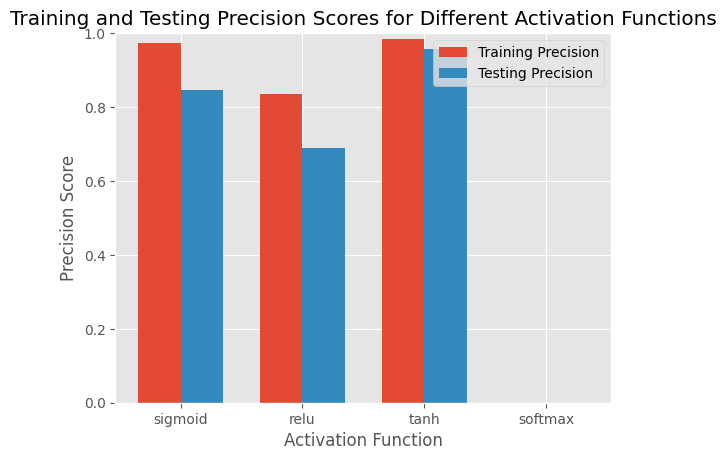

In [347]:
# Plotting the bar graph
bar_width = 0.35

index = np.arange(len(activation_func))

plt.bar(index, precision_scores_train, bar_width, label='Training Precision')
plt.bar(index + bar_width, precision_scores_test, bar_width, label='Testing Precision')

plt.xlabel('Activation Function')
plt.ylabel('Precision Score')
plt.title('Training and Testing Precision Scores for Different Activation Functions')
plt.xticks(index + bar_width / 2, activation_func)
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit to ensure scores are between 0 and 1
plt.show()

In [291]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, input_shape=(1000,)))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='sigmoid'))
model.add(layers.Dense(100, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['precision'])

model.summary()

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ (None, 1000, 50)       │     6,771,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 500)            │    25,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,822,051 (121.39 MB)

 Trainable params: 31,822,051 (121.39 MB)

 Non-trainable params: 0 (0.00 B)

Training precision: 0.9818
Testing precision:  0.6715


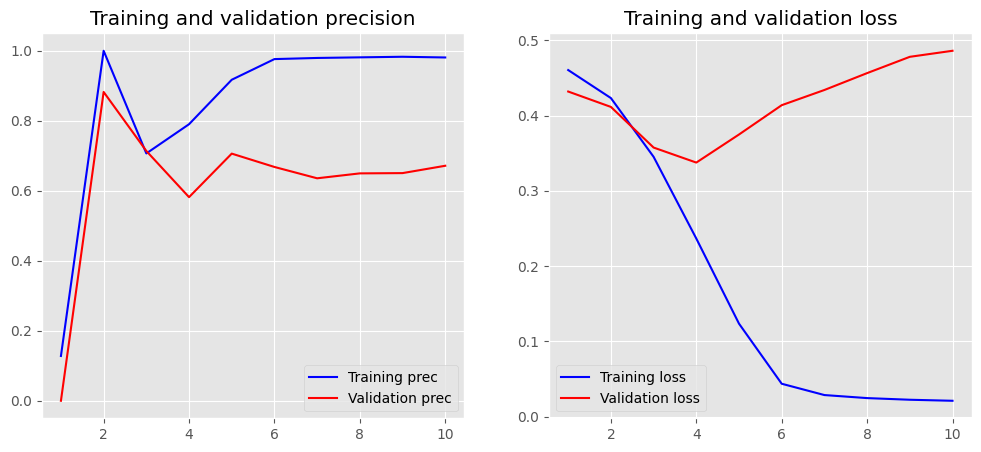

In [292]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=500)

loss, precision = model.evaluate(X_train, y_train, verbose=False)
print("Training precision: {:.4f}".format(precision))
loss, precision = model.evaluate(X_test, y_test, verbose=False)
print("Testing precision:  {:.4f}".format(precision))
plot_history(history)


### Deep Neural Network using GloVe

In [158]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [161]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.200d.txt', tokenizer.word_index, embedding_dim)

In [162]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.45646732187820743

In [164]:
model = Sequential()

embedding_layer = layers.Embedding(vocab_size, embedding_dim, input_shape=(1000,), trainable=False)
model.add(embedding_layer)

embedding_layer.set_weights([embedding_matrix])

# model.add(layers.Embedding(vocab_size, embedding_dim, 
#                            weights=[embedding_matrix], 
#                            input_length=maxlen, 
#                            trainable=False))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['precision'])
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 1000, 50)       │     6,771,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 500)            │        25,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,847,051 (26.12 MB)

 Trainable params: 6,847,051 (26.12 MB)

 Non-trainable params: 0 (0.00 B)

Training precision: 0.6299
Testing precision:  0.5152


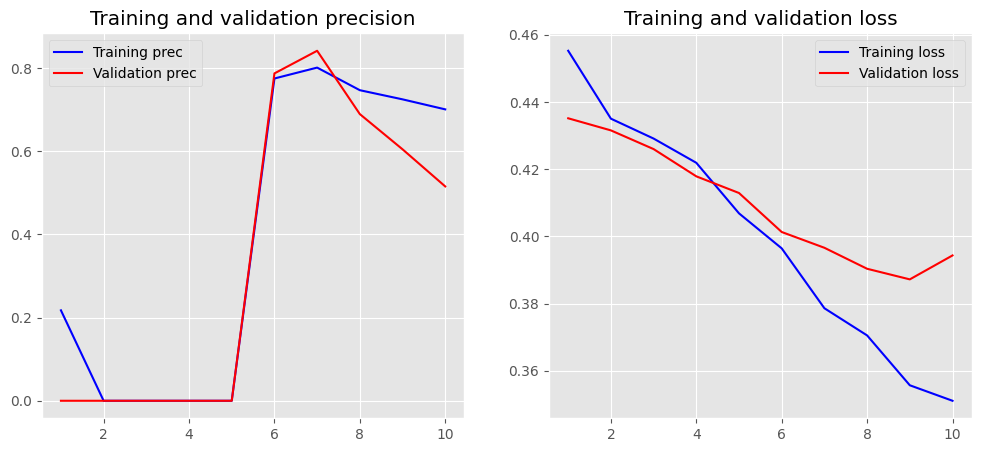

In [165]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=500)

loss, precision = model.evaluate(X_train, y_train, verbose=False)
print("Training precision: {:.4f}".format(precision))
loss, precision = model.evaluate(X_test, y_test, verbose=False)
print("Testing precision:  {:.4f}".format(precision))
plot_history(history)


In [200]:
model = Sequential()

embedding_layer = layers.Embedding(vocab_size, embedding_dim, input_shape=(1000,), trainable=True)
model.add(embedding_layer)

embedding_layer.set_weights([embedding_matrix])

# model.add(layers.Embedding(vocab_size, embedding_dim, 
#                            weights=[embedding_matrix], 
#                            input_length=maxlen, 
#                            trainable=False))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['precision'])
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 1000, 50)       │     6,771,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 500)            │        25,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,047,851 (26.89 MB)

 Trainable params: 7,047,851 (26.89 MB)

 Non-trainable params: 0 (0.00 B)

Training precision: 0.7604
Testing precision:  0.6518


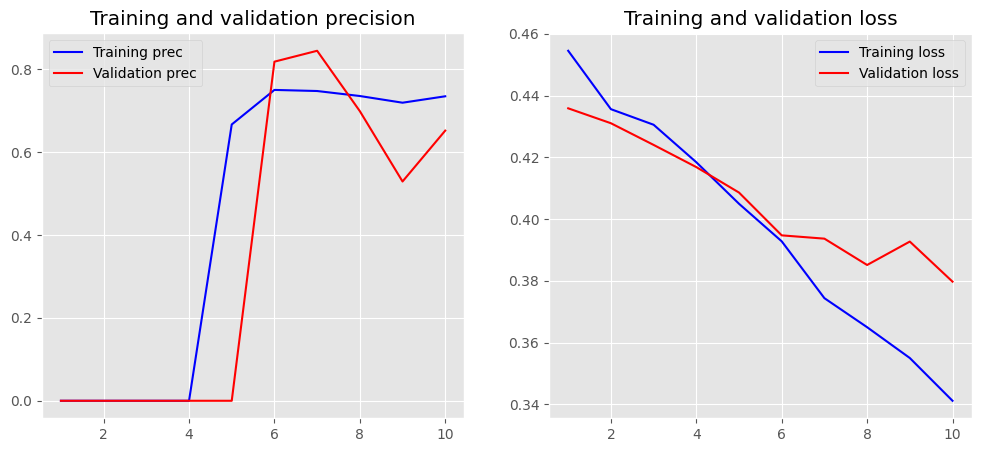

In [201]:
deepNN = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=500)

loss, precision = model.evaluate(X_train, y_train, verbose=False)
print("Training precision: {:.4f}".format(precision))
loss, precision = model.evaluate(X_test, y_test, verbose=False)
print("Testing precision:  {:.4f}".format(precision))
plot_history(deepNN)


### Pre-Processing the Test Dataset

In [189]:
test_data = pd.read_parquet('relevance_test.parquet')

In [190]:
test_data.shape

(4884, 9)

In [191]:
test_data.head(3)

,doc_id,author,body,byline,title,topic_id,description,narrative,topic_title
2050,0002e4f816c863e4b912d6d97dcb68ad,Max Bearak,<p>The United Nations Human Rights Committee <...,By Max Bearak,A U.N. judgment says Ireland’s anti-abortion l...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2051,000c86ea-55df-11e2-bf3e-76c0a789346f,Simson Garfinkel,"<p>In January 1976, Ray Kurzweil introduced th...",By Simson Garfinkel,‘How to Create a Mind: The Secret of Human Tho...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2052,001b27476dfbcdd1431b1607419d83af,Burke Balch,"<p><strong><em>Each week, </em><a href=""http:/...",By Burke Balch,Why are we more interested in pushing death th...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals


In [192]:
test_data.isnull().any()

doc_id         False
author          True
body            True
byline          True
title          False
topic_id       False
description    False
narrative      False
topic_title    False
dtype: bool

In [193]:
# test_data = test_data.dropna(subset=['author', 'body', 'byline'])
import random
import string

# Function to generate random text
def generate_random_text(length):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

# Assuming 'df' is your DataFrame and 'text_columns' is a list of text columns
text_columns = ['author', 'body', 'byline']

for column in text_columns:
    test_data[column] = test_data[column].fillna(generate_random_text(50))  # Replace '50' with desired length of random text



In [194]:
test_data.head(3)

,doc_id,author,body,byline,title,topic_id,description,narrative,topic_title
2050,0002e4f816c863e4b912d6d97dcb68ad,Max Bearak,<p>The United Nations Human Rights Committee <...,By Max Bearak,A U.N. judgment says Ireland’s anti-abortion l...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2051,000c86ea-55df-11e2-bf3e-76c0a789346f,Simson Garfinkel,"<p>In January 1976, Ray Kurzweil introduced th...",By Simson Garfinkel,‘How to Create a Mind: The Secret of Human Tho...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2052,001b27476dfbcdd1431b1607419d83af,Burke Balch,"<p><strong><em>Each week, </em><a href=""http:/...",By Burke Balch,Why are we more interested in pushing death th...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals


In [195]:
# Applying text cleaning function to each column of the training dataset
test_data[['body', 'title', 'description', 'narrative']] = test_data[['body', 'title', 'description', 'narrative']].applymap(text_cleaning)

/var/folders/m_/d9ytr15j7xs96j0pg4x6z7dm0000gn/T/ipykernel_68642/860189693.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [196]:
test_data['combined_text'] = test_data['body'] + test_data['description'] + test_data['narrative'] + test_data['title']

In [197]:
test_data_articles = test_data['combined_text'].copy()

In [204]:
test_data_articles

2050     unit nation human right committe announc rule ...
2051     januari 1976 ray kurzweil introduc kurzweil re...
2052     week theori take big idea news explor rang per...
2053     obama administr decid jettison healthcare.gov ...
2054     adolesc year peopl 's bodi suppos start ascent...
                               ...                        
24957    british author arrest person said link lizard ...
24958    interest gift receipt box-offic receipt holida...
24959    accord 60 percent technolog expert interview p...
24960    honolulu — obama administr ask china help coun...
24961    cybersecur came mani time 2013 easi miss quick...
Name: combined_text, Length: 4884, dtype: object

### Pre-processing and Training the model on whole data

In [205]:
articles

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(articles)

all_articles = tokenizer.texts_to_sequences(articles)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 1000
all_articles = pad_sequences(all_articles, padding='post', maxlen=maxlen)

In [206]:
all_articles

array([[1099,    7,  382, ...,    0,    0,    0],
       [ 427, 4954,  510, ...,    0,    0,    0],
       [ 996,    7,  382, ...,    0,    0,    0],
       ...,
       [1863,   16, 1806, ...,    0,    0,    0],
       [   1, 1478,  517, ...,    0,    0,    0],
       [  36, 1566,    1, ...,    0,    0,    0]], dtype=int32)

In [475]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, input_shape=(1000,)))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['precision'])

model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 1000, 100)      │    15,746,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 100000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 500)            │    50,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,797,601 (251.00 MB)

 Trainable params: 65,797,601 (251.00 MB)

 Non-trainable params: 0 (0.00 B)

In [476]:
history = model.fit(all_articles, Y,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=500)

# loss, precision = model.evaluate(X_train, y_train, verbose=False)
# print("Training precision: {:.4f}".format(precision))
# loss, precision = model.evaluate(X_test, y_test, verbose=False)
# print("Testing precision:  {:.4f}".format(precision))
# plot_history(history)


#### Pre-processing test data for deep layer NN

In [209]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(test_data_articles)

test_articles = tokenizer.texts_to_sequences(test_data_articles)

vocab_size = len(tokenizer.word_index) + 1

In [210]:
maxlen = 1000

test_articles = pad_sequences(test_articles, padding='post', maxlen=maxlen)


In [211]:
test_articles

array([[  62,   38,  237, ...,    0,    0,    0],
       [1983, 1634, 1574, ...,    0,    0,    0],
       [  85, 1535,   47, ...,    0,    0,    0],
       ...,
       [ 159, 1012,   31, ...,    0,    0,    0],
       [   7,   75,  272, ...,    0,    0,    0],
       [2492,  389,   46, ...,    0,    0,    0]], dtype=int32)

In [535]:
test_pred = model.predict(test_articles)

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [536]:
prediction_binary_deep = np.round(test_pred > 0.5).flatten()

In [537]:
# Creating dataframe of Id and judgement for kaggle submission
test_pred_df = pd.DataFrame({'id': test_data['doc_id'], 'judgement': prediction_binary_deep})
print(test_pred_df)

                                         id  judgement
2050       0002e4f816c863e4b912d6d97dcb68ad        0.0
2051   000c86ea-55df-11e2-bf3e-76c0a789346f        0.0
2052       001b27476dfbcdd1431b1607419d83af        0.0
2053   001eb05a-719e-11e3-8b3f-b1666705ca3b        0.0
2054       0058b29067c414f21b35c8f64cb49e64        0.0
...                                     ...        ...
24957      fe097e53be7e8feec1ef4ffdf9f54c4f        0.0
24958      fec727ff7c20faa1bb65d664cc459c59        0.0
24959      ff4c7b7a86185b580010f20fad44a6d5        0.0
24960  ffc37f8c-8885-11e4-9534-f79a23c40e6c        0.0
24961      fffc88ac6c905b50636aa9052e0010f7        0.0

[4884 rows x 2 columns]


In [538]:
test_pred_df[test_pred_df['judgement'] == 1]

,id,judgement
2059,0134975400a8411d82af981fc47743ec,1.0
2121,1b6aa322-14c0-11e3-a100-66fa8fd9a50c,1.0
2234,4ccb99e8-04ea-11e3-a07f-49ddc7417125,1.0
2314,6aeb4307b9ee6b478acb9d360a4f566f,1.0
2353,79b715e4-a35d-11e1-aef3-06a23666ac1d,1.0
...,...,...
22871,b2294a52-dfe3-11e5-846c-10191d1fc4ec,1.0
22925,d56bb69f4d2a1e8009bdf7698f4b255c,1.0
22953,e4ebdb4845e70754ca6ed2ac6b57e9cc,1.0
24660,41311d899c9d1e779fa43c3f611dcae6,1.0


In [513]:
# Converting dataframe to csv
test_pred_df.to_csv('relevance_prediction_deepNN.csv', index=False)

### Pre processing test data with DeepNN using GloVe

In [255]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [256]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.200d.txt', tokenizer.word_index, embedding_dim)

In [258]:
model = Sequential()

embedding_layer = layers.Embedding(vocab_size, embedding_dim, input_shape=(1000,), trainable=True)
model.add(embedding_layer)

embedding_layer.set_weights([embedding_matrix])

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['precision'])
model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 1000, 50)       │     3,724,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 500)            │        25,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,001,001 (15.26 MB)

 Trainable params: 4,001,001 (15.26 MB)

 Non-trainable params: 0 (0.00 B)

In [259]:
history = model.fit(all_articles, Y,
                    epochs=10,
                    verbose=False,
                    batch_size=500)

In [212]:
test_pred_deepNN_glove = model.predict(test_articles)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [266]:
prediction_binary_deep_glove = np.round(test_pred_deepNN_glove > 0.5).flatten()

In [267]:
# Creating dataframe of Id and judgement for kaggle submission
test_pred_df = pd.DataFrame({'id': test_data['doc_id'], 'judgement': prediction_binary_deep_glove})
print(test_pred_df)

                                         id  judgement
2050       0002e4f816c863e4b912d6d97dcb68ad        0.0
2051   000c86ea-55df-11e2-bf3e-76c0a789346f        0.0
2052       001b27476dfbcdd1431b1607419d83af        0.0
2053   001eb05a-719e-11e3-8b3f-b1666705ca3b        0.0
2054       0058b29067c414f21b35c8f64cb49e64        0.0
...                                     ...        ...
24957      fe097e53be7e8feec1ef4ffdf9f54c4f        0.0
24958      fec727ff7c20faa1bb65d664cc459c59        0.0
24959      ff4c7b7a86185b580010f20fad44a6d5        0.0
24960  ffc37f8c-8885-11e4-9534-f79a23c40e6c        0.0
24961      fffc88ac6c905b50636aa9052e0010f7        0.0

[4884 rows x 2 columns]


In [268]:
test_pred_df[test_pred_df['judgement'] == 1]

,id,judgement
2062,01a5d839a0c7288ec696b32cce76a703,1.0
2073,07569f42637702e61277ba4f04b197ef,1.0
2119,1afb5766-6c86-11e2-8740-9b58f43c191a,1.0
2207,404d4e4dd62d47680f6f15dfcbf6e011,1.0
2354,7ab35878-2a59-11e5-bd33-395c05608059,1.0
2506,ba432c365ddb8dbad389b4b8a0a65ff4,1.0
2527,c4cf63967137f49bb5ed95843e50a062,1.0
2539,ca962539653a8c0963980f326b3adfb6,1.0
2648,fd272cee-231b-11e4-958c-268a320a60ce,1.0
5090,2b891e86-2f39-11e7-a335-fa0ae1940305,1.0


In [269]:
# Converting dataframe to csv
test_pred_df.to_csv('relevance_prediction_deepNN_glove.csv', index=False)

0.86841

### Performing TF-IDF 

In [522]:
articles_test = list(test_data['combined_text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(articles_test)
articles_test = tfidf_vectorizer_vectors.toarray()

In [523]:
articles_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01968212, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01668843, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Model Training on Whole Training Data for SGD
In order to validate our models, split the training dataset into training and validation set. To use actual test dataset which is completely unseen during training, models were trained on entire training set rather than just a subset of training set.

In [524]:
sgd_clf = SGDClassifier(loss='log_loss', random_state=42)
sgd_clf.fit(X, Y)

SGDClassifier(loss='log_loss', random_state=42)

In [526]:
X_test22 = articles_test

In [527]:
# Fitting the model on test dataset
test_pred = sgd_clf.predict(X_test22)

In [530]:
# Fitting with 3 layer NN
prediction_binary = np.round(test_pred > 0.5).flatten()

In [531]:
# Creating dataframe of Id and judgement for kaggle submission
test_pred_df = pd.DataFrame({'id': test_data['doc_id'], 'judgement': prediction_binary })
print(test_pred_df)

                                         id  judgement
2050       0002e4f816c863e4b912d6d97dcb68ad        0.0
2051   000c86ea-55df-11e2-bf3e-76c0a789346f        0.0
2052       001b27476dfbcdd1431b1607419d83af        0.0
2053   001eb05a-719e-11e3-8b3f-b1666705ca3b        0.0
2054       0058b29067c414f21b35c8f64cb49e64        0.0
...                                     ...        ...
24957      fe097e53be7e8feec1ef4ffdf9f54c4f        0.0
24958      fec727ff7c20faa1bb65d664cc459c59        0.0
24959      ff4c7b7a86185b580010f20fad44a6d5        0.0
24960  ffc37f8c-8885-11e4-9534-f79a23c40e6c        0.0
24961      fffc88ac6c905b50636aa9052e0010f7        0.0

[4884 rows x 2 columns]


In [532]:
test_pred_df[test_pred_df['judgement'] == 1]

,id,judgement


In [157]:
# Converting dataframe to csv
test_pred_df.to_csv('relevance_prediction.csv', index=False)